<a href="https://colab.research.google.com/github/123shwetarohokale/lammps-aluminum-optimization/blob/main/LAMMPS_Al_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/123shwetarohokale/lammps-aluminum-optimization.git
%cd lammps-aluminum-optimization

Cloning into 'lammps-aluminum-optimization'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 140 (delta 71), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 5.23 MiB | 5.43 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/lammps-aluminum-optimization/lammps-aluminum-optimization


In [5]:
import os
print(os.getcwd())
print(os.listdir())

/content/lammps-aluminum-optimization/lammps-aluminum-optimization
['submittensile-job.sh', 'energy_time_series.dat', 'Al99.eam.alloy', '.git', 'gitignore (1).txt', 'energy_convergence.log', 'Copy_of_analyze_energy.ipynb', 'al.data-lattice.out', 'Al_tens_100.def1.txt', 'LAMMPS_Al_Simulation.ipynb', 'in_tensile.nvt', 'in.nvt', 'log.lammps', 'in_lattice_eng.nvt', 'al.dat.out', 'submit-job.sh', 'Al99.eam (3).alloy', '.gitignore.txt', 'README.md', 'timing_energy_lat4.log', 'analyze_energy.ipynb', 'in_autocorrelation.nvt', 'submitenergycon-job.sh', 'in_lattice.nvt', 'submitlattice-job.sh', 'al.o1856655']


Reached end of Atoms section.
✅ Total atoms read: 62500


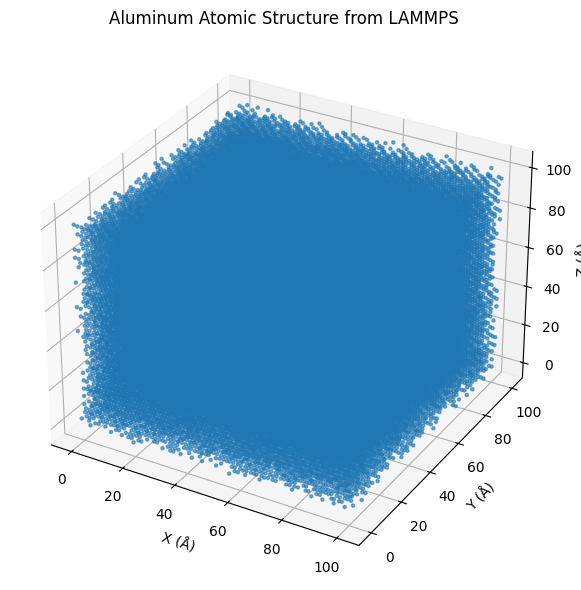

In [ ]:
# Aluminum Atomic Structure from LAMMPS:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

positions = []
reading_atoms = False
atom_section_started = False

# ✅ Use correct file name
with open("al.data-lattice.out") as file:
    for line in file:
        if "Atoms # atomic" in line:
            reading_atoms = True
            continue
        if reading_atoms:
            # Skip blank lines after header
            if not atom_section_started:
                if line.strip() == "":
                    continue
                else:
                    atom_section_started = True  # Start reading actual data

            # Stop at the next section or unexpected line
            if line.strip() == "" or line[0].isalpha():
                print("Reached end of Atoms section.")
                break

            parts = line.strip().split()
            if len(parts) >= 5:
                try:
                    x, y, z = float(parts[2]), float(parts[3]), float(parts[4])
                    positions.append([x, y, z])
                except ValueError:
                    print("Line skipped (bad float):", line.strip())
            else:
                print("Line skipped (too few columns):", line.strip())

positions = np.array(positions)
print(f"✅ Total atoms read: {len(positions)}")

# Plot if data is valid
if positions.ndim == 2 and positions.shape[1] == 3:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=5, alpha=0.6)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title('Aluminum Atomic Structure from LAMMPS')

    plt.tight_layout()
    plt.show()
else:
    print("❌ Error: No valid atomic coordinates found.")


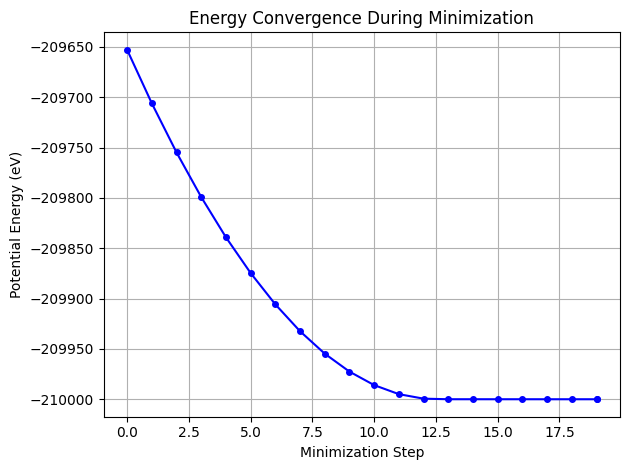

In [15]:
# Energy convergence during minimization
import matplotlib.pyplot as plt

steps = []
energies = []

with open("energy_convergence.log", "r") as f:
    for line in f:
        if line.strip().startswith("Step") or line.startswith("Loop"):
            continue
        tokens = line.strip().split()
        if len(tokens) >= 2:
            try:
                steps.append(int(tokens[0]))
                energies.append(float(tokens[1]))  # PE
            except ValueError:
                continue

plt.figure()
plt.plot(steps, energies, 'b-o', markersize=4)
plt.xlabel("Minimization Step")
plt.ylabel("Potential Energy (eV)")
plt.title("Energy Convergence During Minimization")
plt.grid(True)
plt.tight_layout()
plt.savefig("energy_convergence.png", dpi=300)
plt.show()

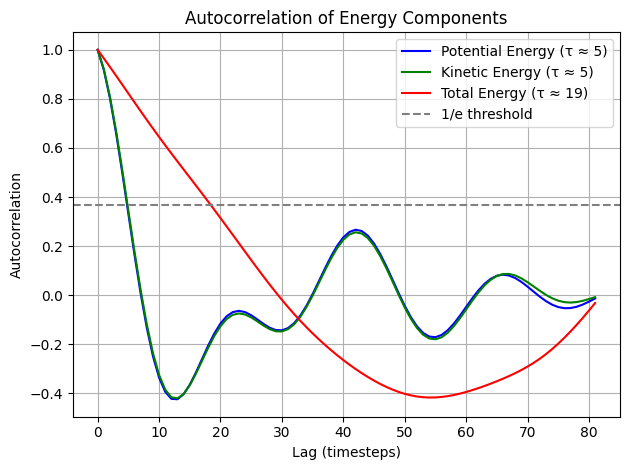


 Estimated Number of Independent Samples with Time Info:

Component            Total_Steps    dt (fs) τ(steps)     τ (fs)     Indep. Samples
--------------------------------------------------------------------------
Potential Energy           82       2.50        5      12.50                  8
Kinetic Energy             82       2.50        5      12.50                  8
Total Energy               82       2.50       19      47.50                  2


In [16]:
# Autocorrelation of energy components
import numpy as np
import matplotlib.pyplot as plt

# Load energy time series (assumes columns: PE, KE, TE)
data = np.loadtxt("energy_time_series.dat")
pe, ke, te = data[:, 0], data[:, 1], data[:, 2]

# User-specified MD parameters
timestep_fs = 2.5  # fs per timestep (match your LAMMPS input)
total_steps = len(pe)

# Define autocorrelation
def autocorr(x):
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size // 2:]
    return result / result[0]

def estimate_tau(acf):
    for i, val in enumerate(acf):
        if val < 1 / np.e:
            return i
    return len(acf)

# Prepare metadata
labels = ['Potential Energy', 'Kinetic Energy', 'Total Energy']
colors = ['b', 'g', 'r']
series = [pe, ke, te]

# Plot autocorrelations
plt.figure()
taus = []
for i, s in enumerate(series):
    ac = autocorr(s)
    tau = estimate_tau(ac)
    taus.append(tau)
    plt.plot(ac[:200], label=f"{labels[i]} (τ ≈ {tau})", color=colors[i])

plt.axhline(1 / np.e, color='gray', linestyle='--', label='1/e threshold')
plt.xlabel('Lag (timesteps)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Energy Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("autocorr_all_energies.png", dpi=300)
plt.show()

# Print summary table
print("\n Estimated Number of Independent Samples with Time Info:\n")
print(f"{'Component':20} {'Total_Steps':>8} {'dt (fs)':>10} {'τ(steps)':>8} {'τ (fs)':>10} {'Indep. Samples':>18}")
print("-" * 74)

for i, tau in enumerate(taus):
    tau_fs = tau * timestep_fs
    n_indep = int(total_steps / (2 * tau)) if tau > 0 else total_steps
    print(f"{labels[i]:20} {total_steps:>8} {timestep_fs:>10.2f} {tau:>8} {tau_fs:>10.2f} {n_indep:>18}")

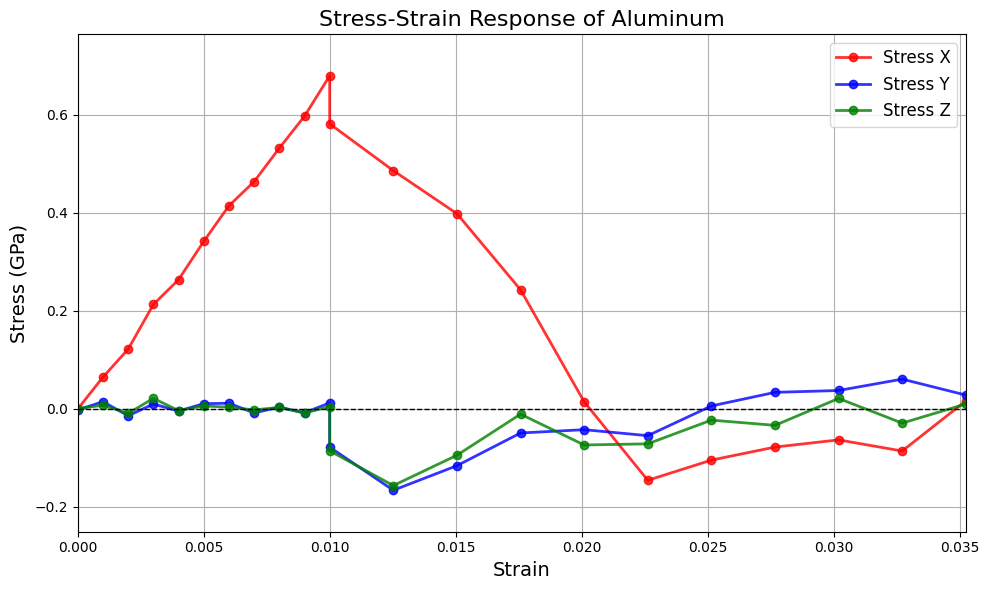

In [13]:
# Stress-Strain response of Aluminum
import matplotlib.pyplot as plt
import numpy as np
import csv

# Read data
results = []
with open('Al_tens_100.def1.txt', newline='') as file:
    reader = csv.reader(file, delimiter=' ')
    next(reader)  # Skip header
    for row in reader:
        row_clean = [float(i) for i in row if i.strip()]
        if len(row_clean) == 4:
            results.append(row_clean)

results2 = np.transpose(results)

# Get min/max for y-axis (stress) to accommodate negatives
stress_all = np.concatenate([results2[1], results2[2], results2[3]])
stress_min = min(stress_all)
stress_max = max(stress_all)
buffer = (stress_max - stress_min) * 0.1  # 10% padding

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(results2[0], results2[1], 'o-', label='Stress X', lw=2, markersize=6, alpha=0.8, color='red')
plt.plot(results2[0], results2[2], 'o-', label='Stress Y', lw=2, markersize=6, alpha=0.8, color='blue')
plt.plot(results2[0], results2[3], 'o-', label='Stress Z', lw=2, markersize=6, alpha=0.8, color='green')

plt.axhline(0, color='black', linestyle='--', lw=1)  # Add horizontal line at 0

plt.xlabel('Strain', fontsize=14)
plt.ylabel('Stress (GPa)', fontsize=14)
plt.title('Stress-Strain Response of Aluminum', fontsize=16)
plt.legend(fontsize=12)
plt.xlim(0, max(results2[0]))
plt.ylim(stress_min - buffer, stress_max + buffer)
plt.grid(True)
plt.tight_layout()
plt.show()
